# 🔧How It Works: The "Naive" Approach

This project uses a classic probabilistic method to classify text. Since computers can't read English directly, we have to convert the messages into a format they understand: **Probability Vectors**.

Here is the 3-step breakdown of the logic used in this notebook:

### 1. Weighing the Words (TF-IDF)
Instead of just counting how many times a word appears (which makes common words like "the" look important), we used **TF-IDF** (*Term Frequency - Inverse Document Frequency*).
* **TF:** How often a word appears in *this* message.
* **IDF:** How rare the word is across *all* messages.
* **Result:** Unique keywords like **"prize"** or **"urgent"** get a heavy weight, while common filler words get a score near zero.

### 2. The Brain: Multinomial Naive Bayes
We used `MultinomialNB`, which is the industry standard for text classification. It operates on a simple principle based on **Bayes' Theorem**:

$$P(Spam | Word) \propto P(Word | Spam) \times P(Spam)$$

It calculates the probability that a message is spam given the words inside it. It represents a **"Naive"** approach because it assumes every word is independent (it doesn't care about sentence order), yet it remains surprisingly accurate because spam messages rely heavily on specific trigger keywords.

### 3. The "Impact Score"
In the final visualization, we extracted the **Feature Log Probabilities** from the model to interpret the results.
* The model assigns a probability score to every word in the vocabulary for both classes (Ham vs Spam).
* By subtracting the Ham score from the Spam score (`spam_prob - ham_prob`), we derive an **Impact Score**.
* **High Impact Score:** Words like `claim`, `won`, and `service` drastically increase the chance of a message being flagged.
* **Low Impact Score:** Words like `home`, `later`, and `sorry` act as "safety" words, pulling the probability back towards "Ham."

Import all the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns


Import the Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Intel IoT Colab/spam.csv", encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

Data Visualization

In [ ]:
label_counts=df['label'].value_counts()


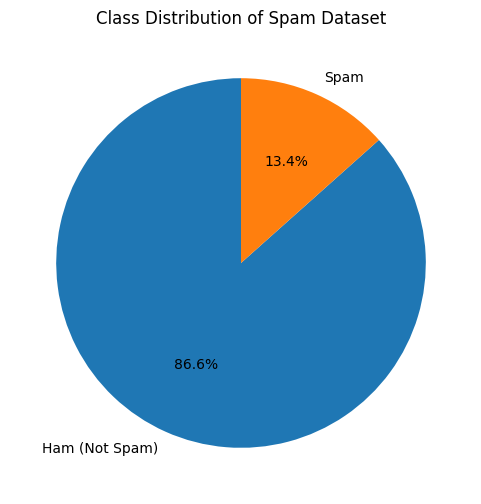

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(
    label_counts,
    labels=['Ham (Not Spam)', 'Spam'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Class Distribution of Spam Dataset")
plt.show()

Label Encoding

In [ ]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


Text -> Numerical Features through TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True
)

X = vectorizer.fit_transform(df['text'])
y = df['label']


Test-Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Model

In [ ]:
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

Model Evaluation


In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.968609865470852
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.77      0.87       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.93      1115
weighted avg       0.97      0.97      0.97      1115



<Axes: >

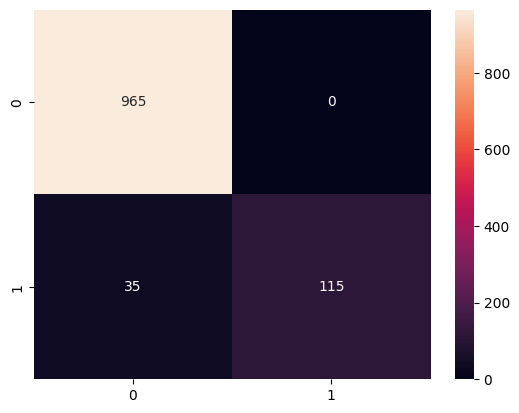

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')


/tmp/ipython-input-164873033.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_spam, x='impact_score', y='word', palette='Reds_r')
/tmp/ipython-input-164873033.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_ham, x='impact_score', y='word', palette='Blues')


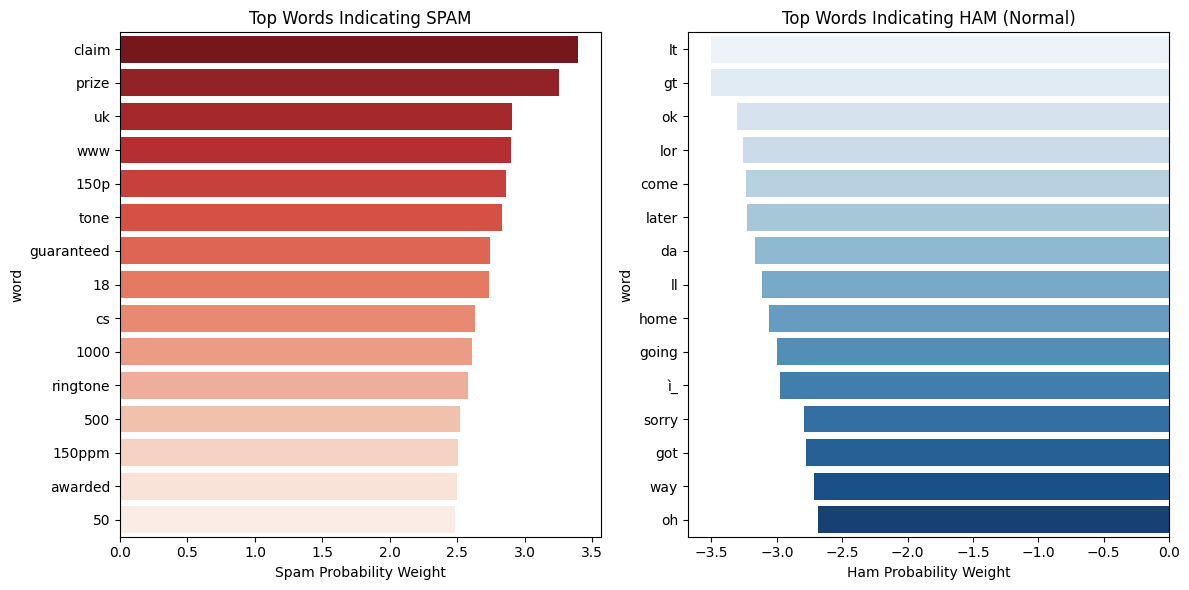

In [ ]:
# Create a DataFrame to store feature names and their log-probabilities
feature_names = vectorizer.get_feature_names_out()
# log_prob_ shape is (n_classes, n_features) -> class 1 is Spam
spam_prob = model.feature_log_prob_[1]
ham_prob = model.feature_log_prob_[0]

words_df = pd.DataFrame({
    'word': feature_names,
    'spam_log_prob': spam_prob,
    'ham_log_prob': ham_prob
})

# Calculate the difference (Impact Score)
# Words with high positive difference are strongly associated with Spam
words_df['impact_score'] = words_df['spam_log_prob'] - words_df['ham_log_prob']

# Get top 15 words for Spam and Ham
top_spam = words_df.sort_values(by='impact_score', ascending=False).head(15)
top_ham = words_df.sort_values(by='impact_score', ascending=True).head(15)

# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=top_spam, x='impact_score', y='word', palette='Reds_r')
plt.title('Top Words Indicating SPAM')
plt.xlabel('Spam Probability Weight')

plt.subplot(1, 2, 2)
sns.barplot(data=top_ham, x='impact_score', y='word', palette='Blues')
plt.title('Top Words Indicating HAM (Normal)')
plt.xlabel('Ham Probability Weight')

plt.tight_layout()
plt.show()